### Importing the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pil
import skimage as im
import amglib.readers as io
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed
from skimage.morphology import binary_erosion as erode
from skimage.morphology import binary_dilation as dilate
from skimage.morphology import disk
from skimage.morphology import h_maxima
import skimage.morphology.greyreconstruct as gr
from skimage.morphology import label
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import matplotlib.colors as colors
from skimage.color      import hsv2rgb, rgb2hsv
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

%matplotlib inline
#%matplotlib widget

import importlib
importlib.reload(io)

C:\Users\kaestner\git\CBCTCalibration\amglib\imageutils.py:8: FutureWarning: Importing from skimage.morphology.greyreconstruct is deprecated. Please import from skimage.morphology instead.
  import skimage.morphology.greyreconstruct as rec


<module 'amglib.readers' from 'C:\\Users\\kaestner\\git\\CBCTCalibration\\amglib\\readers.py'>

### Importing Datapath where the images are stored

In [2]:
datapath = 'L:/ICON dez. 2020/Tomography/00_Calibration/02_CBCTCal/' 

In [74]:
dc=io.read_images(datapath+'dc_{:05}.fits',first=1,last=10,averageStack=True,average='mean');
ob=io.read_images(datapath+'ob_{:05}.fits',first=1,last=10,averageStack=True,average='mean');
cal=io.read_images(datapath+'cbctcal_{:05}.fits',first=1,last=360,stride=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

### Normalize

In [75]:
ob1=ob-dc
np.nan_to_num(ob1)
ob1[ob1<=0]=1
print(dc.min(),dc.max(),dc.mean())
print(ob1.min(),ob1.max(),ob1.mean())

0.0 65535.0 2958.2234
0.2000122 37629.902 20492.248


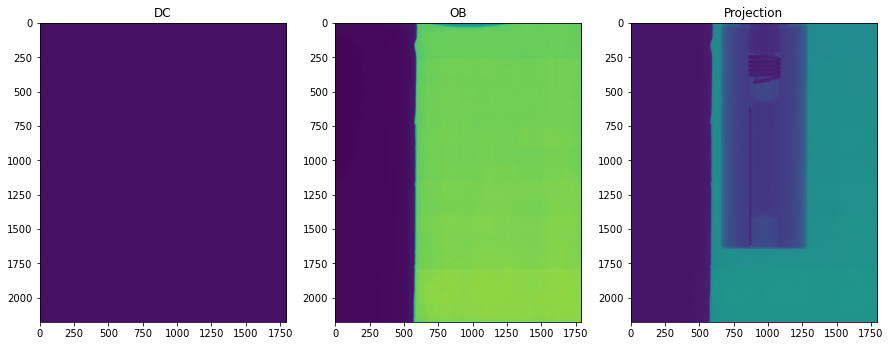

In [76]:
fig, ax = plt.subplots(1,3,figsize=(15,7))
ax=ax.ravel()
ax[0].imshow(dc)
ax[0].set_title('DC')
ax[1].imshow(ob1)
ax[1].set_title('OB')
ax[2].imshow(cal[1,:,:]) #,vmin=0.0,vmax=10000)
ax[2].set_title('Projection');

In [77]:
def normalizeData(img,ob,dc) :
    for idx in np.arange(0, img.shape[0]):
        tmp=(img[idx,:,:]-dc)
        tmp[tmp<=0]=1
        img[idx,:,:]=(tmp/ob)
    lcal=-np.log(img)
    
    return lcal

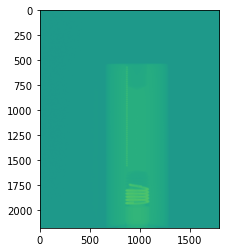

In [78]:
lcal=normalizeData(cal,ob1,dc)
flipProjection = True
if flipProjection : 
    lcal = lcal[:,::-1,:]
    
plt.imshow(lcal[1,:,:])

### Removing unwanted elements from the image - optional depending on how much extra background is captured

In [88]:
new_lcal=lcal
new_lcal[:,0:800]=0
new_lcal[:,1600:]=0

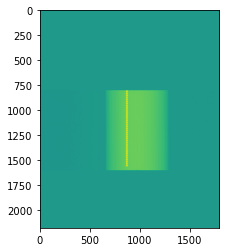

In [89]:
plt.imshow(new_lcal[1,:,:])

In [90]:
lcal=new_lcal

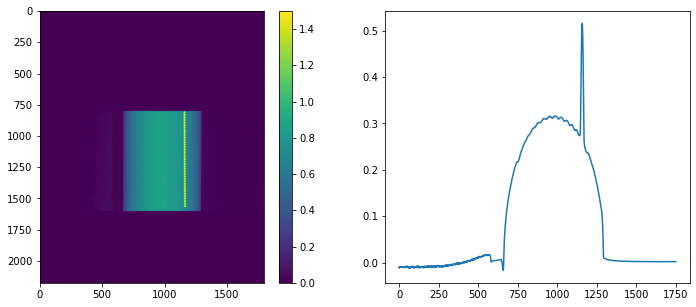

In [91]:
idx=10
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.imshow(lcal[idx,:,:],vmin=0,vmax=1.5)
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(lcal[idx,:,:].mean(axis=0)[:1750])

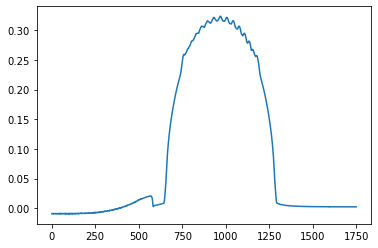

In [92]:
baseline = lcal.mean(axis=0).mean(axis=0)
baseline = baseline.reshape(1,baseline.shape[0])
plt.plot(baseline.ravel()[:1750])

In [93]:
print(lcal.shape)

(36, 2176, 1792)


### Removing Baseline

In [94]:
def removeBaseline(img) :
    img=img[:,:,0:1750]
    baseline = img.mean(axis=0).mean(axis=0)
    baseline = baseline.reshape(1,baseline.shape[0])

    b2=np.matmul(np.ones([img.shape[1],1]),baseline)
    res=img;
    print(b2.shape,res.shape)
    for idx in np.arange(0,img.shape[0]) :
        res[idx,:,:]=res[idx,:,:]-b2
    return res

bcal=removeBaseline(lcal)

(2176, 1750) (36, 2176, 1750)


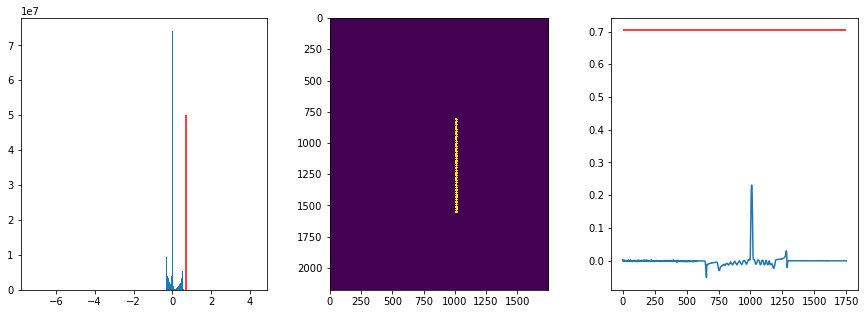

In [95]:
idx=5
m = bcal.mean()
s = bcal.std()
k=3.3
fig,ax=plt.subplots(1,3,figsize=[15,5])
ax[0].hist(bcal.ravel(),bins=256)
ax[0].vlines(m+k*s,ymin=0,ymax=5e7,color='r')
im=ax[1].imshow(m+k*s < bcal[idx,:,:],interpolation='None')
ax[2].plot(bcal[idx,:,:].mean(axis=0));
ax[2].hlines(m+k*s,xmin=0, xmax=bcal.shape[2],color='r');

In [96]:
def thresholdBBs(img,k) :
    s=bcal.std()
    m=bcal.mean()
    
    return (m+k*s)< img

tcal=thresholdBBs(bcal,3.3)

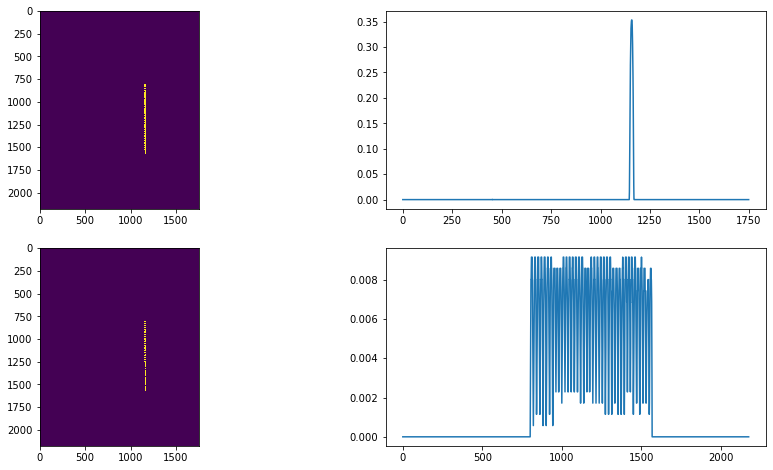

In [97]:
from skimage.transform import rescale, resize, downscale_local_mean
idx=10
fig,ax = plt.subplots(2,2,figsize=(15,8))
ax=ax.ravel()
ax[0].imshow(tcal[idx,:,:],interpolation='None')
ax[1].plot(tcal[idx,:,:].mean(axis=0))
ecal = erode(tcal[idx,:,:],disk(2))
ax[2].imshow(ecal,interpolation='None')
ax[3].plot(ecal.mean(axis=1))

### Watershed Segmentation

In [98]:
def min_impose(dimg,markers) :
    fm=markers.copy()
    fm[markers != 0] = 0
    fm[markers == 0] = dimg.max()
    dimg2 = np.minimum(fm,dimg+1)
    res   = gr.reconstruction(fm,dimg2,method='erosion')
    
    return res

def randomCM(N, low=0.2, high=1.0,seed=42, bg=0) :
    np.random.seed(seed=seed)
    clist=np.random.uniform(low=low,high=high,size=[N,3]); 
    m = ortho_group.rvs(dim=3)
    if bg is not None : 
        clist[0,:]=bg;
        
    rmap = ListedColormap(clist)
    
    return rmap

def goldenCM(N,increment=1.0,s=0.5,v=0.7,bg=0) :
    phi= 0.5*(np.sqrt(5)-1)
    
    hsv = np.zeros([N,3]);
    hsv[:, 0] = increment*phi*np.linspace(0,N-1,N)-np.floor(increment*phi*np.linspace(0,N-1,N))
    hsv[:, 1] = s
    hsv[:, 2] = v
    rgb = hsv2rgb(hsv)
    if bg is not None : rgb[0,:]=bg    
    cm = ListedColormap(rgb) 
    return cm

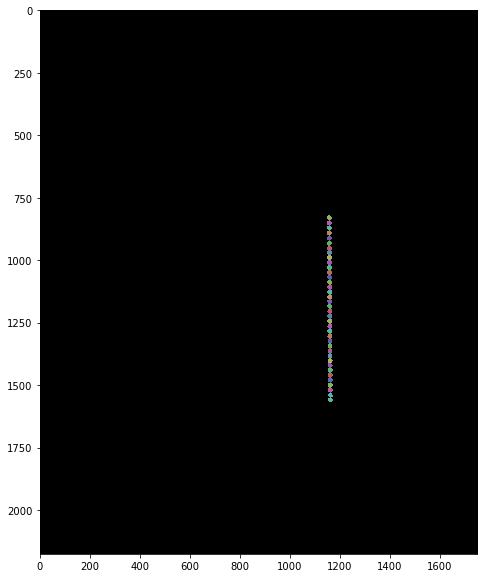

In [99]:
from skimage.measure import label, regionprops, regionprops_table

img = tcal[idx,:,:]
distance = ndi.distance_transform_edt(img)

h=2
localmax = h_maxima(distance,h)
rdmap    = distance.max()-distance
labels   = label(localmax)
ws1 = watershed(min_impose(rdmap,labels),labels,mask=img)
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(ws1,interpolation='None',cmap=goldenCM(labels.max()))

### Figuring out beads

In [100]:
rp = regionprops_table(ws1,properties=('area','centroid'))
cog=np.zeros([rp['centroid-0'].shape[0],2])
cog[:,0]=rp['centroid-0']
cog[:,1]=rp['centroid-1']

In [101]:
def findBeadsWS(img, selem= disk(3),h=2) :
    distance = ndi.distance_transform_edt(erode(img,selem))

    localmax = h_maxima(distance,h)
    rdmap    = distance.max()-distance
    labels   = label(localmax)
    ws1 = watershed(min_impose(rdmap,labels),labels,mask=img)
    
    rp = regionprops_table(ws1,properties=('area','centroid'))
       
    cog=np.zeros([rp['centroid-0'].shape[0],2])
    cog[:,0]=rp['centroid-0']
    cog[:,1]=rp['centroid-1']
    return cog

def findBeads(img, selem, c = 1.96) :
    eimg = erode(img,selem)
     
    labels = label(eimg)
    ll = {}
    for i in np.arange(0, labels.max()+1):
        a = np.sum(labels==i)
        if (a<np.prod(img.shape)/2) :
            ll[i]=a
    m = np.mean(list(ll.values()))
    s = np.std(list(ll.values()))
    
    cog=[]
    for lbl in ll :
        selection=np.argwhere(labels==lbl)
        if ((len(selection)<m+c*s) and (m-c*s<len(selection))):
            cog.append(selection.mean(axis=0))
       
    cog=np.asarray(cog)
    return cog


def buildBeadList(img,selem=disk(12),c=1.96) :
    beadlist = []

    for idx in np.arange(0, img.shape[2]) :
        cog=findBeadsWS(img[:,:,idx],selem,c)
        beadlist.append(cog)

    return beadlist

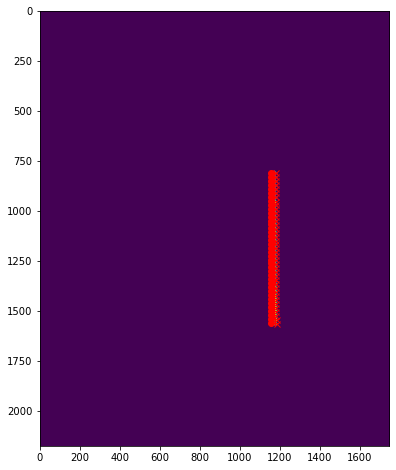

In [102]:
idx=11
c=4
cog=findBeadsWS(tcal[idx,:,:])

plt.figure(figsize=[12,8])
plt.imshow(tcal[idx,:,:])

plt.plot(cog[:,1]-1,cog[:,0]-1,'r+')

cog1=findBeadsWS(tcal[idx+1,:,:])
plt.plot(cog1[:,1]-1,cog1[:,0]-1,'rx')

cog2=findBeadsWS(tcal[idx-1,:,:])
plt.plot(cog2[:,1]-1,cog2[:,0]-1,'ro')

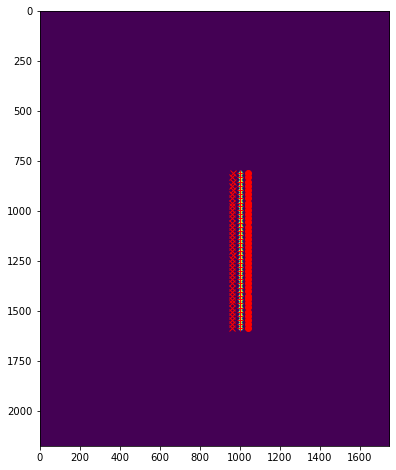

In [103]:
idx=21
c=4
cog=findBeadsWS(tcal[idx,:,:])

plt.figure(figsize=[12,8])
plt.imshow(tcal[idx,:,:])

plt.plot(cog[:,1]-1,cog[:,0]-1,'r+')

cog1=findBeadsWS(tcal[idx+1,:,:])
plt.plot(cog1[:,1]-1,cog1[:,0]-1,'rx')

cog2=findBeadsWS(tcal[idx-1,:,:])
plt.plot(cog2[:,1]-1,cog2[:,0]-1,'ro')

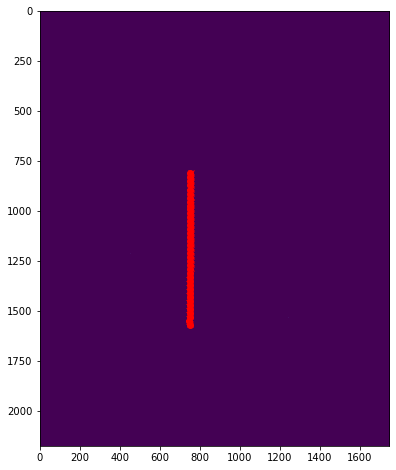

In [104]:
idx=31
c=k
cog=findBeadsWS(tcal[idx,:,:])

plt.figure(figsize=[12,8])
plt.imshow(tcal[idx,:,:])

plt.plot(cog[:,1]-1,cog[:,0]-1,'r+')

cog1=findBeadsWS(tcal[idx+1,:,:])
plt.plot(cog1[:,1]-1,cog1[:,0]-1,'rx')

cog2=findBeadsWS(tcal[idx-1,:,:])
plt.plot(cog2[:,1]-1,cog2[:,0]-1,'ro')

### Plotting Corresponding ellipses

In [105]:
def medianDistance(cog) :
    return np.median(np.diff(cog[:,0]))

def itemList(cog) :
    d=medianDistance(cog)
    idx=np.floor((cog[:,0]-cog[0,0])/d+0.5).astype(int)
    
    idxList={}
    for (i,c) in zip(idx,cog) :
        idxList[i]=c
        
    return idxList

def pruneEllipse(e) :
    pe = 1
    
def identifyEllipses(img,selem,c) :
    N=img.shape[0]
    ellipses = {}
        
    for proj in tqdm(np.arange(0,N)) :
        cog = findBeads(img[proj,:,:])
        cogIdx = itemList(cog)
        for idx in cogIdx :
            if idx in ellipses :
                ellipses[idx] = np.vstack([ellipses[idx], cogIdx[idx]])
            else :
                ellipses[idx] = cogIdx[idx]
        
    
    return ellipses

def identifyEllipses2(img,selem) :
    N=img.shape[0]
    ellipses = []
    params=[]
    cog_allbeads=[]    
    beads = []
    for proj in tqdm(np.arange(0,N)) :
        cog = findBeadsWS(img[proj,:,:])
        beads.append(cog)


    for idx in range(len(min(beads,key=len))):
        ellipse = []
        for p in range(N) :
            ellipse.append(beads[p][idx,:].tolist())
        ellipses.append(np.array(ellipse))
        ell = EllipseModel()
        a_ellipse = np.array(ellipse)
        ell.estimate(a_ellipse)
        if ell.params==None:
            continue
        cog_onebead=[]
        for p in range(N) :
            cog_onebead.append(beads[p][idx,:])
        cog_allbeads.append(cog_onebead)
        xc, yc, a, b, theta = ell.params
        print("ID Number = ", idx)
        print("center = ",  (xc, yc))
        print("angle of rotation = ",  theta)
        print("axes = ", (a,b))
        x=a_ellipse[:,0]
        y=a_ellipse[:,1]
        fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
        axs[0].scatter(x, y)

        axs[1].scatter(x, y)
        axs[1].scatter(xc, yc, color='red', s=100)
#         axs[1].set_xlim(x.min(), x.max())
#         axs[1].set_ylim(y.min(), y.max())

        ell_patch = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')

        axs[1].add_patch(ell_patch)
        plt.show()
        params.append([xc,yc,a,b,theta])
    return params,cog_allbeads

  0%|          | 0/36 [00:00<?, ?it/s]

ID Number =  1
center =  (832.1778955658854, 969.2094650881127)
angle of rotation =  0.0015684252844010507
axes =  (1.6362200905926267, 232.2491719883813)


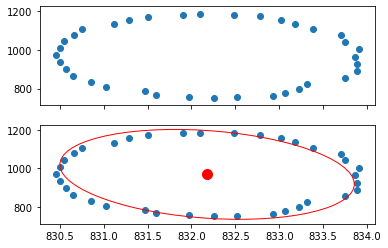

ID Number =  2
center =  (852.7426363083968, 969.0932902965327)
angle of rotation =  0.000712993390748953
axes =  (2.0722586597404953, 228.46964049485393)


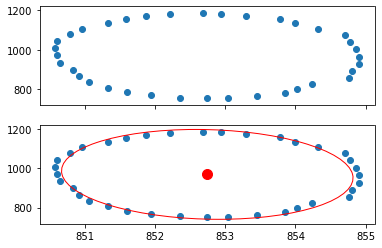

ID Number =  3
center =  (873.4298927876694, 990.640678861824)
angle of rotation =  1.5714671723272928
axes =  (360.0770260654811, 2.0696890056154613)


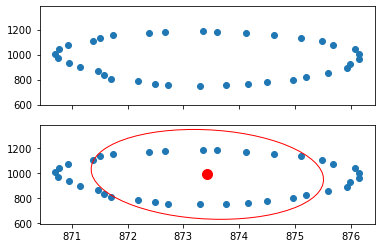

ID Number =  4
center =  (893.736990738677, 968.9852607192386)
angle of rotation =  1.5709567158797433
axes =  (199.17190608655395, 3.470272595029253)


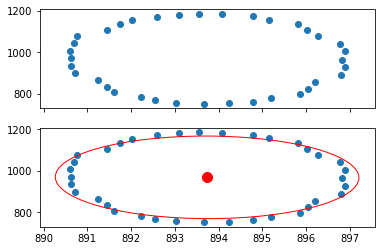

ID Number =  5
center =  (914.268131673104, 968.8443905827963)
angle of rotation =  1.5709696078085287
axes =  (197.70974580664245, 4.024401282733998)


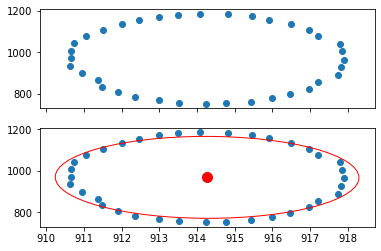

ID Number =  6
center =  (934.8158999636786, 970.5994804015917)
angle of rotation =  0.00022818460936127786
axes =  (4.312930428149821, 204.7446860508934)


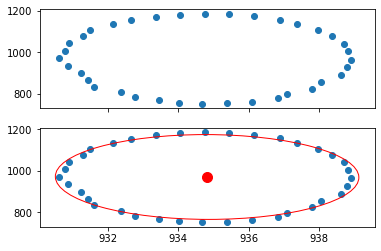

ID Number =  7
center =  (955.3053268151185, 967.9123456309354)
angle of rotation =  1.570961052571002
axes =  (224.7169186241072, 4.366684730832318)


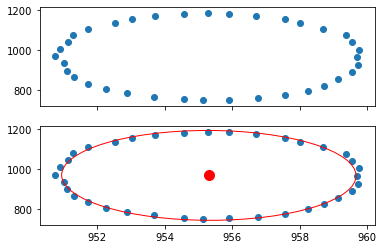

ID Number =  8
center =  (973.9776218240246, 969.5909157554693)
angle of rotation =  0.00014568845200700042
axes =  (5.003475453063222, 214.2049863685892)


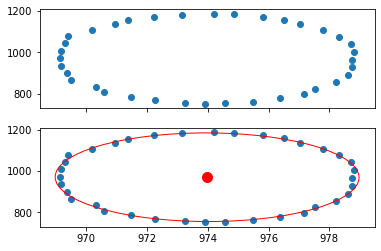

ID Number =  10
center =  (1012.679459678374, 968.5388646311459)
angle of rotation =  -5.071951205440019e-06
axes =  (5.807323759312098, 218.32935426309564)


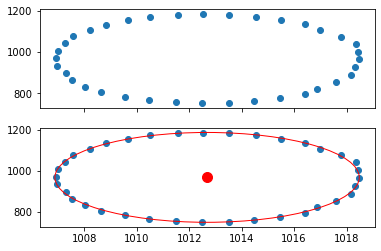

ID Number =  11
center =  (1032.7166493507546, 969.7666923819787)
angle of rotation =  -6.107869209712465e-05
axes =  (6.287634889088061, 217.1894401243967)


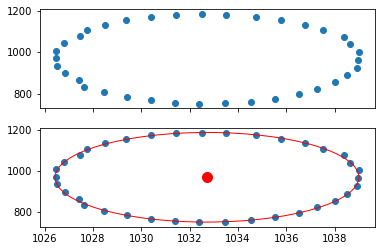

ID Number =  12
center =  (1052.7841837289686, 967.7400853197405)
angle of rotation =  1.5709973667948192
axes =  (217.17783874924945, 6.739680104262957)


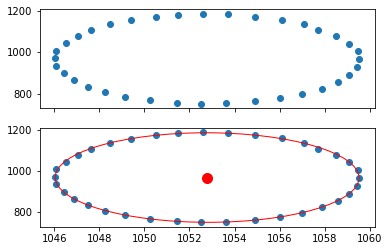

ID Number =  13
center =  (1072.5198870876125, 967.3900365433241)
angle of rotation =  1.570918142239631
axes =  (218.3836240391422, 7.164343881064195)


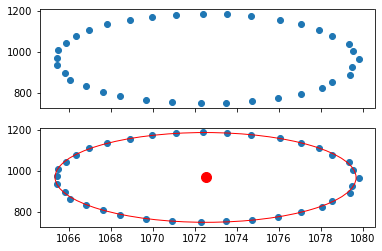

ID Number =  14
center =  (1092.3561846490472, 968.8770062502138)
angle of rotation =  -4.830203386123447e-05
axes =  (7.638114686547686, 217.60387455193984)


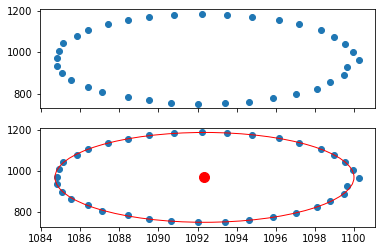

ID Number =  15
center =  (1112.383006065153, 968.9814814831014)
angle of rotation =  -4.461470877048171e-05
axes =  (8.092817602773577, 217.41423140252385)


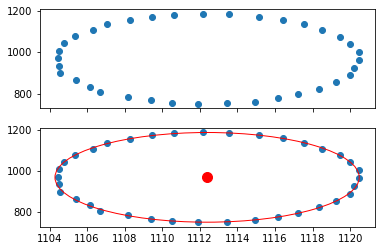

ID Number =  16
center =  (1132.5723561037528, 968.4751038668971)
angle of rotation =  0.0001424824863937913
axes =  (8.548273770315124, 217.970840296629)


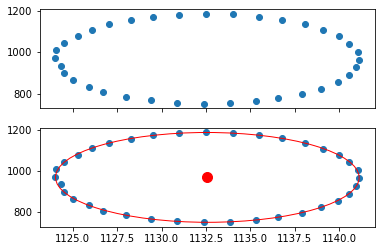

ID Number =  17
center =  (1152.4926602955363, 966.503251999651)
angle of rotation =  -0.0002415948646540247
axes =  (9.112335395548177, 217.91384694988247)


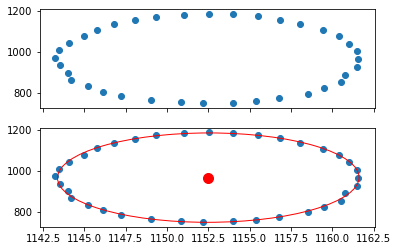

ID Number =  18
center =  (1170.989938098693, 968.2540467132973)
angle of rotation =  -0.00018818681694339826
axes =  (9.562170264794167, 217.64016703426032)


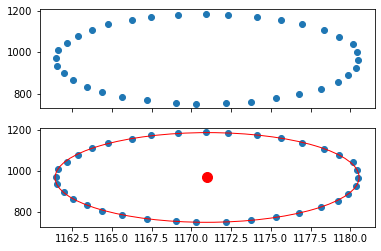

ID Number =  19
center =  (1189.999075846463, 969.0188106167965)
angle of rotation =  1.5708833495407424
axes =  (218.33428716798184, 9.896886770798123)


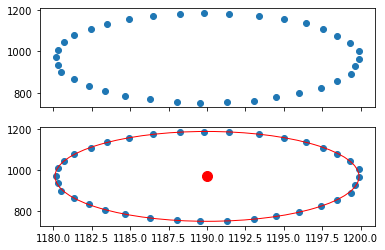

ID Number =  20
center =  (1209.9857253936557, 969.2791445778453)
angle of rotation =  0.00014846324386731782
axes =  (10.338270659984426, 218.48550656060831)


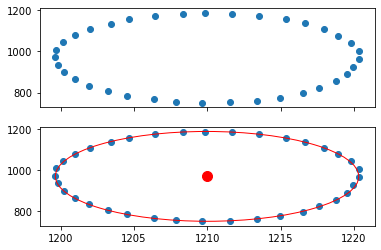

ID Number =  21
center =  (1230.1431678561858, 968.8893676419118)
angle of rotation =  1.570742067903855
axes =  (218.5636459185914, 10.843014608093583)


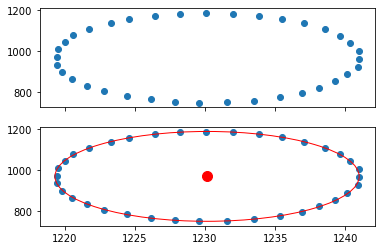

ID Number =  22
center =  (1250.3302996613709, 969.2355320619636)
angle of rotation =  1.5708509957493977
axes =  (218.7526405743898, 11.293499347388282)


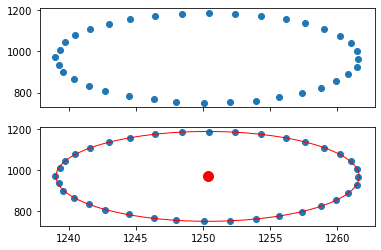

ID Number =  23
center =  (1270.2768940307603, 968.7827592543484)
angle of rotation =  1.5709203005039003
axes =  (219.09256796220566, 11.775677404839557)


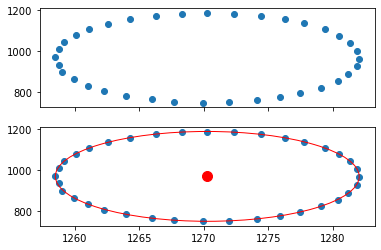

ID Number =  24
center =  (1290.3371067011728, 968.5419839268123)
angle of rotation =  0.00019248602071153832
axes =  (12.308189475112655, 218.873545598898)


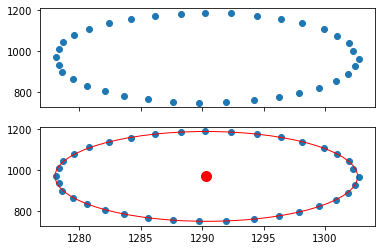

ID Number =  25
center =  (1310.691338630621, 968.6015645913587)
angle of rotation =  1.5708133983031578
axes =  (219.11484339941296, 12.743172323184833)


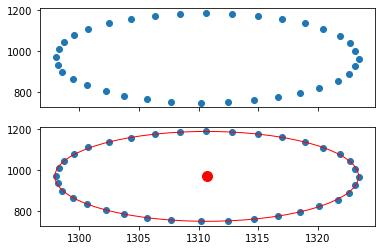

ID Number =  26
center =  (1330.6674988726643, 968.8730769037538)
angle of rotation =  1.5705759880719057
axes =  (219.2376377150656, 13.172118195747155)


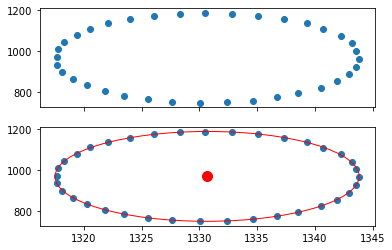

ID Number =  27
center =  (1350.622347689803, 969.1046802577075)
angle of rotation =  1.5709161292963916
axes =  (219.8732470276822, 13.628122631077147)


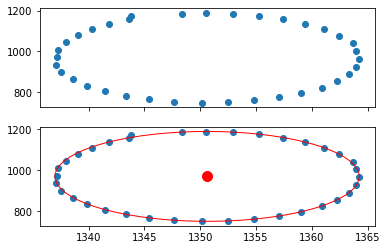

ID Number =  28
center =  (1369.6718785784285, 978.4466400826759)
angle of rotation =  1.5829472319794136
axes =  (220.06914704739214, 14.939125522896267)


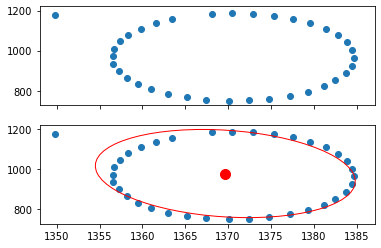

ID Number =  29
center =  (1389.1103692197523, 981.0082861972552)
angle of rotation =  1.5874674036440788
axes =  (217.71026439808563, 16.039395294944516)


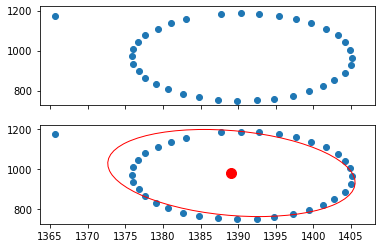

ID Number =  30
center =  (1409.008970831703, 980.4409675773353)
angle of rotation =  1.5868358310446602
axes =  (218.65609275499682, 16.40178669848556)


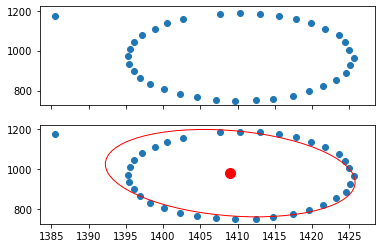

ID Number =  31
center =  (1428.0994807124198, 980.1672218660634)
angle of rotation =  1.5854564091846002
axes =  (219.30432822362843, 16.568324704034296)


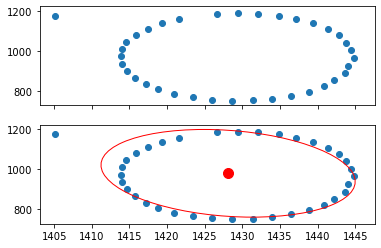

ID Number =  32
center =  (1447.1866506220174, 978.9336679741758)
angle of rotation =  1.5851546793357734
axes =  (219.6602472332691, 17.002476914003775)


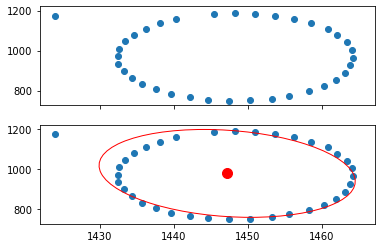

ID Number =  33
center =  (1467.3675029345825, 979.4255064549546)
angle of rotation =  1.5866413450499917
axes =  (218.84114458432114, 17.69899640200755)


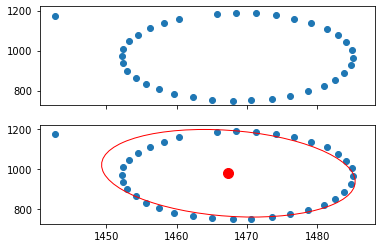

ID Number =  34
center =  (1487.5640372987941, 979.0007183007206)
angle of rotation =  1.5864362384510167
axes =  (219.58794534978486, 18.09467259428182)


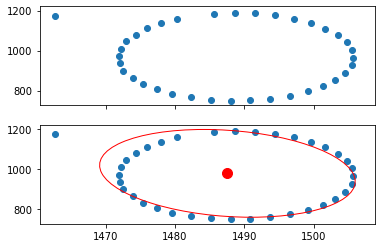

ID Number =  35
center =  (1507.8230292760911, 979.0740129558635)
angle of rotation =  1.5861009057620028
axes =  (220.34640833399573, 18.53393007542085)


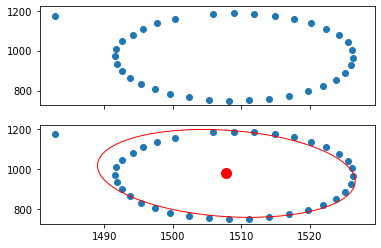

ID Number =  36
center =  (1528.1408907823247, 978.8160042169676)
angle of rotation =  0.014840496736496784
axes =  (18.91674181815172, 220.6812546780109)


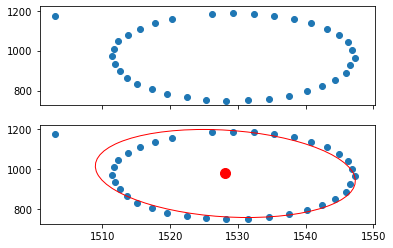

ID Number =  37
center =  (1548.0862443256326, 977.6243410944196)
angle of rotation =  1.5845899011724445
axes =  (222.18817066458192, 19.361147016963226)


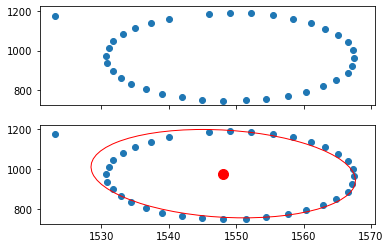

ID Number =  38
center =  (1567.9793726852633, 977.8288028572816)
angle of rotation =  1.5845124030587694
axes =  (221.57851167845712, 19.673230407376963)


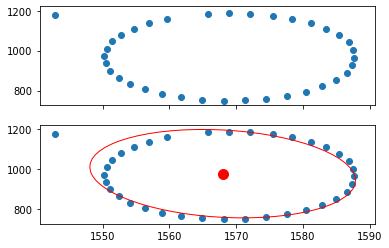

In [107]:
[e2,cog_allbeads]=identifyEllipses2(tcal,selem=disk(2))

In [32]:
len(e2) , len(cog_allbeads)

(38, 38)

In [108]:
#Removing the first 10 ellipse and beads entries to remove the outliers
n=10
del e2[0:8]
#del e2[24:]

In [109]:
del cog_allbeads[0:3]
#del cog_allbeads[24:]

In [110]:
len(e2) , len(cog_allbeads)

(29, 34)

### Estimating COR and tilt about the center

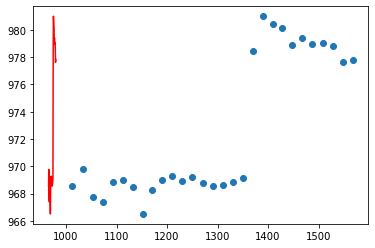

In [111]:
x_centres=[]
y_centres=[]
for i in range(len(e2)):
    x_centres.append(e2[i][1])
    y_centres.append(e2[i][0])
theta=np.polyfit(y_centres, x_centres, 1)

plt.scatter(y_centres,x_centres)
plt.plot(theta[1]+theta[0]*np.array(y_centres), x_centres, 'r')
plt.show()

In [56]:
print("The parameters of the COR obtained are as follows:",(theta[0], theta[1]))

The parameters of the COR obtained are as follows: (0.0006841883521170855, 967.8409512817067)


#### Final value of COR can be obtained by subtractin the projection value taken 

In [57]:
tilt = np.arctan(theta[0])*180/np.pi
print("The tilt of the center of rotation is in degrees: ", tilt)

The tilt of the center of rotation is in degrees:  0.039201098851463265


### Estimating Piercing Point

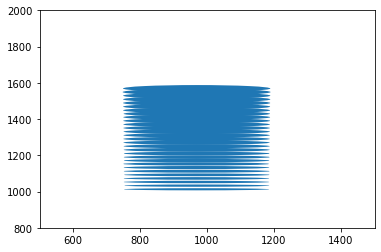

In [58]:
fig, ax = plt.subplots()

for idx in range(len(e2)):
    ellipse = Ellipse((e2[idx][1], e2[idx][0]), e2[idx][3]*2, e2[idx][2]*2, e2[idx][4])
    ax.add_artist(ellipse)

ax.set_xlim(500, 1500)
ax.set_ylim(800, 2000)

plt.show()

In [59]:
radius=[]
height=[]
for i in range(len(e2)):
    radius.append(e2[i][2])
    height.append(e2[i][0])

(700.0, 1600.0)

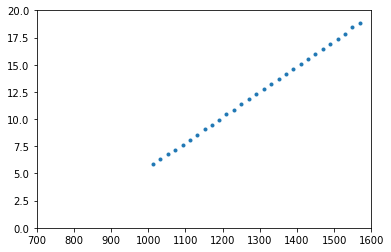

In [114]:
plt.plot(height,radius,'.')
ax=plt.gca()
ax.set_ylim([0,20])
ax.set_xlim([700,1600])

In [62]:
i = np.argmin(radius)
x_min = height[i]
y_min = e2[i][1]
print(x_min, y_min)

1012.6249383358855 968.5306809460907


In [63]:
vpiercing= y_min
hpiercing= x_min

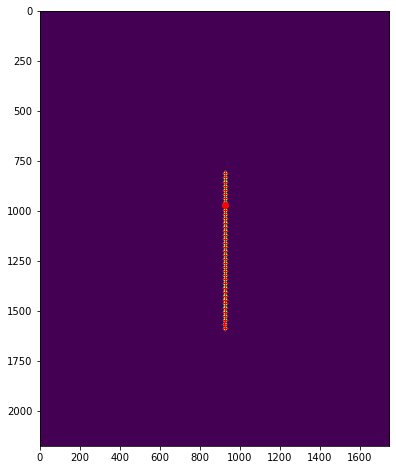

In [64]:
idx=21
c=2.5
cog=findBeadsWS(tcal[idx,:,:])

plt.figure(figsize=[12,8])
plt.imshow(tcal[idx,:,:])

plt.plot(cog[:,1]-1,cog[:,0]-1,'r+')
plt.plot(cog[10,1]-1,vpiercing,'ro')

### Estimating SOD and SDD

In [65]:
def estDistances(h,ha,hb,R) :
    H = np.array([[1,-h/ha], [1,-h/hb]])
    y = np.array([-R,R])
        
    est=np.linalg.solve(H,y)
    
    return est

In [66]:
pixelSize = 0.139
R = 10
c0=itemList(findBeadsWS(tcal[0,:,:]))
sod = []
sdd = [] 
for idx in range(np.array(e2).shape[0]) :
    ha=(e2[idx][0]-e2[idx][2]-vpiercing) * pixelSize
    hb=(e2[idx][0]+e2[idx][2]-vpiercing) * pixelSize
    h=0
    if idx in c0 :
        h = (c0[idx][0]-vpiercing)*pixelSize
    est_sod= (hb+ha)*R/(hb-ha)
    est_sdd= ((est_sod-R)*hb)/h
    sod.append(np.abs(est_sod))
    sdd.append(np.abs(est_sdd))
    print("h: {0:0.3f}, S0D: {1:0.2f}, SDD: {2:0.2f}, magn: {3:0.2f}".format(h,est_sod, est_sdd,est_sdd/est_sod))

sod = np.mean(sod)
sdd = np.mean(sdd)
            
print("Mean SOD= ", sod)
print("Mean SDD= ", sdd)
print("Magnification= ", sdd/sod)

h: -22.006, S0D: 75.09, SDD: -20.54, magn: -0.27
h: -19.172, S0D: 101.42, SDD: -46.73, magn: -0.46
h: -16.356, S0D: 124.54, SDD: -88.60, magn: -0.71
h: -13.549, S0D: 144.57, SDD: -153.42, magn: -1.06
h: -10.799, S0D: 161.89, SDD: -256.99, magn: -1.59
h: -8.012, S0D: 177.62, SDD: -441.77, magn: -2.49
h: -5.218, S0D: 191.21, SDD: -833.32, magn: -4.36
h: -2.425, S0D: 203.27, SDD: -2139.48, magn: -10.53
h: 0.116, S0D: 213.79, SDD: 51656.09, magn: 241.62
h: 2.686, S0D: 222.63, SDD: 2545.57, magn: 11.43
h: 5.351, S0D: 231.54, SDD: 1449.39, magn: 6.26
h: 8.081, S0D: 240.63, SDD: 1080.98, magn: 4.49
h: 10.829, S0D: 247.82, SDD: 894.83, magn: 3.61
h: 13.517, S0D: 254.83, SDD: 789.56, magn: 3.10
h: 16.189, S0D: 261.71, SDD: 722.21, magn: 2.76
h: 18.920, S0D: 267.68, SDD: 671.97, magn: 2.51
h: 21.677, S0D: 273.11, SDD: 633.31, magn: 2.32
h: 24.386, S0D: 278.96, SDD: 606.77, magn: 2.18
h: 26.893, S0D: 283.58, SDD: 588.52, magn: 2.08
h: 29.468, S0D: 288.62, SDD: 573.75, magn: 1.99
h: 32.208, S0D: 2

## Appendix - Extra Code snippets 

In [67]:
pixelSize = 0.139
R = 10
c0=itemList(findBeadsWS(tcal[0,:,:]))
sod = []
sdd = [] 


for idx in range(np.array(e2).shape[0]) :
    ha=(e2[idx][1]-e2[idx][2]-hpiercing) * pixelSize
    hb=(e2[idx][1]+e2[idx][2]-hpiercing) * pixelSize
    if idx in c0 :
        h = (c0[idx][0]-hpiercing)*pixelSize
        est = estDistances(h,ha,hb,R)
        sod.append(np.abs(est[0]))
        sdd.append(np.abs(est[1]))
        print("h: {0:0.3f}, S0D: {1:0.2f}, SDD: {2:0.2f}, magn: {3:0.2f}".format(h,est[0], est[1], est[1]/est[0]))

sod = np.mean(sod)
sdd = np.mean(sdd)
            
print("Mean SOD= ", sod)
print("Mean SDD= ", sdd)
print("Magnification= ", sdd/sod)

h: -28.135, S0D: -75.09, SDD: -16.07, magn: 0.21
h: -25.301, S0D: -68.41, SDD: -15.92, magn: 0.23
h: -22.485, S0D: -65.79, SDD: -17.68, magn: 0.27
h: -19.678, S0D: -61.72, SDD: -18.84, magn: 0.31
h: -16.928, S0D: -56.71, SDD: -19.56, magn: 0.35
h: -14.141, S0D: -54.14, SDD: -22.53, magn: 0.42
h: -11.347, S0D: -51.73, SDD: -27.07, magn: 0.52
h: -8.554, S0D: -50.18, SDD: -35.58, magn: 0.71
h: -6.013, S0D: -46.47, SDD: -45.09, magn: 0.97
h: -3.443, S0D: -43.91, SDD: -73.41, magn: 1.67
h: -0.778, S0D: -41.89, SDD: -308.38, magn: 7.36
h: 1.952, S0D: -40.19, SDD: 117.28, magn: -2.92
h: 4.700, S0D: -38.50, SDD: 46.48, magn: -1.21
h: 7.388, S0D: -37.28, SDD: 28.73, magn: -0.77
h: 10.060, S0D: -35.86, SDD: 20.15, magn: -0.56
h: 12.791, S0D: -34.32, SDD: 14.97, magn: -0.44
h: 15.548, S0D: -32.90, SDD: 11.64, magn: -0.35
h: 18.257, S0D: -32.03, SDD: 9.66, magn: -0.30
h: 20.764, S0D: -30.95, SDD: 8.14, magn: -0.26
h: 23.339, S0D: -29.96, SDD: 6.95, magn: -0.23
h: 26.079, S0D: -28.89, SDD: 5.92, ma

In [68]:
np.median(np.diff(cog[:,0]))

20.52554653779964

In [69]:
cog=findBeadsWS(tcal[:,:,0])
d=medianDistance(cog)
idx=np.floor((cog[:,0]-cog[0,0])/d+0.5).astype(int)
    
idxList={}
for (i,c) in zip(idx,cog) :
    idxList[i]=c
    
print(idxList)

C:\Users\kaestner\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kaestner\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [70]:
cog

array([], shape=(0, 2), dtype=float64)

In [71]:
distance = np.sqrt((cog[0][0]-cog[1][0])**2 + (cog[0][1]-cog[1][1])**2)
radius = distance/2
print("distance= ", distance)
print("magnification= ", distance/0.139)

IndexError: index 0 is out of bounds for axis 0 with size 0